# Visualizing DIMM Data

This notebook takes the files produced by the nightly runs of the LSST DIMMs on the summit and produces plots to visualize the data.

In [1]:
import numpy as np
import pandas as pd
import corner
from astropy.time import Time
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

## Import and Organize data

First, specify the dates available for analysis in `obs_dates`. The filenames from the DIMM output are stored marked by date with the date formatted as: **YYMMDD**. 
Then set the locations for data from the two DIMMs by specifying the `portable_dimm_folder` and `tower_dimm_folder`.

Once these variables are set run the cell below and it will take the relevant lines from each file and save them to a working file. This is necessary to import the data with pandas since the original files have lines with different lengths based upon the type of output on that line. The type is specified by the first character of each line. For now we take the `F` and `A` outputs from the `preat.stm` files.

Schema for `preat.stm` files can be found here: http://curl.sai.msu.ru/mass/download/doc/preat_desc2e.pdf

In [2]:
obs_dates = ['190907', '190911', '190912', '190913', '190914', '190915', '190916']

portable_dimm_folder = '../../DIMM/portable_data'
tower_dimm_folder = '../../DIMM/tower_data'

for date in obs_dates:

    with open('%s/%s-preat.stm' % (portable_dimm_folder, date)) as f:
        with open('%s/%s-preat-f.dat' % (portable_dimm_folder, date), 'w') as g:
            for line in f:
                if (line[0] == 'F'):
                    g.write(line)

    with open('%s/%s-preat.stm' % (portable_dimm_folder, date)) as f:
        with open('%s/%s-preat-a.dat' % (portable_dimm_folder, date), 'w') as g:
            for line in f:
                if (line[0] == 'A'):
                    g.write(line)
                    
    with open('%s/%s-preat.stm' % (tower_dimm_folder, date)) as f:
        with open('%s/%s-preat-f.dat' % (tower_dimm_folder, date), 'w') as g:
            for line in f:
                if (line[0] == 'F'):
                    g.write(line)
                    
    with open('%s/%s-preat.stm' % (tower_dimm_folder, date)) as f:
        with open('%s/%s-preat-a.dat' % (tower_dimm_folder, date), 'w') as g:
            for line in f:
                if (line[0] == 'A'):
                    g.write(line)

In [3]:
columns = ['prefix',
           'date',
           'mean_utc',
           'airmass',
           'num_frames',
           'mean_flux_left',
           'rms_mean_left',
           'mean_scint_left',
           'mean_flux_right',
           'rms_mean_right',
           'mean_scint_right',
           'corrected_strehl_left',
           'corrected_strehl_right']

preat_f_port = None
preat_f_tower = None
night = 1

for date in obs_dates:

    if preat_f_port is None:
        preat_f_port = pd.read_csv('%s/%s-preat-f.dat' % (portable_dimm_folder, date), names=columns, delim_whitespace=True)
        preat_f_port['night'] = night
    else:
        temp_f_port = pd.read_csv('%s/%s-preat-f.dat' % (portable_dimm_folder, date), names=columns, delim_whitespace=True)
        temp_f_port['night'] = night
        preat_f_port = pd.concat([preat_f_port, temp_f_port]).reset_index(drop=True)
        
    if preat_f_tower is None:
        preat_f_tower = pd.read_csv('%s/%s-preat-f.dat' % (tower_dimm_folder, date), names=columns, delim_whitespace=True)
        preat_f_tower['night'] = night
    else:
        temp_f_tower = pd.read_csv('%s/%s-preat-f.dat' % (tower_dimm_folder, date), names=columns, delim_whitespace=True)
        temp_f_tower['night'] = night
        preat_f_tower = pd.concat([preat_f_tower, temp_f_tower]).reset_index(drop=True)
        
    night += 1

In [4]:
columns = ['prefix',
           'date',
           'mean_utc',
           'full_turb_long',
           'full_turb_trans',
           'full_turb_common',
           'low_freq_turb_long',
           'low_freq_turb_trans',
           'low_freq_turb_common']

preat_a_port = None
preat_a_tower = None
night = 1

for date in obs_dates:

    if preat_a_port is None:
        preat_a_port = pd.read_csv('%s/%s-preat-a.dat' % (portable_dimm_folder, date), names=columns, delim_whitespace=True)
        preat_a_port['night'] = night
    else:
        temp_a_port = pd.read_csv('%s/%s-preat-a.dat' % (portable_dimm_folder, date), names=columns, delim_whitespace=True)
        temp_a_port['night'] = night
        preat_a_port = pd.concat([preat_a_port, temp_a_port]).reset_index(drop=True)
        
    if preat_a_tower is None:
        preat_a_tower = pd.read_csv('%s/%s-preat-a.dat' % (tower_dimm_folder, date), names=columns, delim_whitespace=True)
        preat_a_tower['night'] = night
    else:
        temp_a_tower = pd.read_csv('%s/%s-preat-a.dat' % (tower_dimm_folder, date), names=columns, delim_whitespace=True)
        temp_a_tower['night'] = night
        preat_a_tower = pd.concat([preat_a_tower, temp_a_tower]).reset_index(drop=True)
        
    night += 1

In [5]:
# Should have same number of entries of each type
len(preat_f_port), len(preat_a_port)

(4396, 4396)

In [6]:
# Merge the two file types into one entry for each time
preat_df_port = preat_f_port.join(preat_a_port, how='inner', rsuffix='_right')
preat_df_port = preat_df_port.drop(columns=['prefix', 'prefix_right', 'date_right', 'mean_utc_right', 'night_right'])

preat_df_tower = preat_f_tower.join(preat_a_tower, how='inner', rsuffix='_right')
preat_df_tower = preat_df_tower.drop(columns=['prefix', 'prefix_right', 'date_right', 'mean_utc_right', 'night_right'])

In [7]:
# Add seeing to dataframes
# Formula comes from schema file
def calc_seeing(turb_intensity):
    return (turb_intensity**0.6)*2e7

In [8]:
preat_df_port['full_seeing'] = calc_seeing(preat_df_port['full_turb_common'])
preat_df_port['low_freq_seeing'] = calc_seeing(preat_df_port['low_freq_turb_common'])

preat_df_tower['full_seeing'] = calc_seeing(preat_df_tower['full_turb_common'])
preat_df_tower['low_freq_seeing'] = calc_seeing(preat_df_tower['low_freq_turb_common'])

In [9]:
# Use the time of the first observation in the tower DIMM as a basetime
# Calculate the time in seconds from this first tower observation as an offset
# We will use this to line up the data from the two DIMMs
basetime = Time(preat_df_tower['date'].iloc[0]+'T'+preat_df_tower['mean_utc'].iloc[0])
def time_offset(date_array, utc_array):
    offset = []
    for day, time in zip(date_array, utc_array):
        t = Time(day+'T'+time)
        diff = t-basetime
        offset.append(diff.sec)
    return offset

In [10]:
preat_df_port['time_offset'] = time_offset(preat_df_port['date'].values, preat_df_port['mean_utc'].values)
preat_df_tower['time_offset'] = time_offset(preat_df_tower['date'].values, preat_df_tower['mean_utc'].values)

In [11]:
# Some visits have NaNs. Remove them here
port_good = np.where(~np.isnan(preat_df_port['corrected_strehl_right']))
tower_good = np.where(~np.isnan(preat_df_tower['corrected_strehl_right']))

preat_df_port = preat_df_port.iloc[port_good].reset_index(drop=True)
preat_df_tower = preat_df_tower.iloc[tower_good].reset_index(drop=True)

## Find indices to match up the observations

Find tower and portable DIMM observations that are within 30 seconds of one another and match them together.

In [12]:
near_tower_idx = []
good_port_idx = []
for port_idx in range(len(preat_df_port['time_offset'])):
    port_time = preat_df_port['time_offset'].iloc[port_idx]
    time_diff = np.floor(preat_df_tower['time_offset'] - port_time)
    nearest_tower_idx = np.where(((time_diff > -30.) & (time_diff <= 30.)))
    if len(nearest_tower_idx[0]) > 0:
        if (np.isnan(preat_df_port['full_seeing'].iloc[port_idx])
            or np.isnan(preat_df_tower['full_seeing'].iloc[nearest_tower_idx[0][0]])):
            continue
        elif nearest_tower_idx[0][0] in near_tower_idx:
            continue
        else:
            good_port_idx.append(port_idx)
            near_tower_idx.append(nearest_tower_idx[0][0])

## Visualize results

Now we have the data set up to make plots and look at the results from the DIMM observations.

First we plot the seeing from the DIMMs over a few nights.

Text(0.5, 1.0, 'DIMM seeing side-by-side')

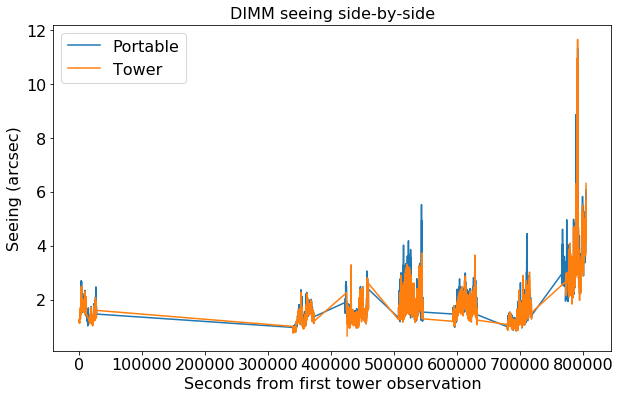

In [13]:
fig = plt.figure(figsize=(10, 6))
plt.plot(preat_df_port['time_offset'], preat_df_port['full_seeing'], label='Portable')
plt.plot(preat_df_tower['time_offset'], preat_df_tower['full_seeing'], label='Tower')
plt.xlabel('Seconds from first tower observation', size=16)
plt.ylabel('Seeing (arcsec)', size=16)
plt.tick_params(axis='both', labelsize=16)
plt.legend(fontsize=16)
plt.title('DIMM seeing side-by-side', size=16)

Now we plot Portable DIMM vs Tower DIMM measurements

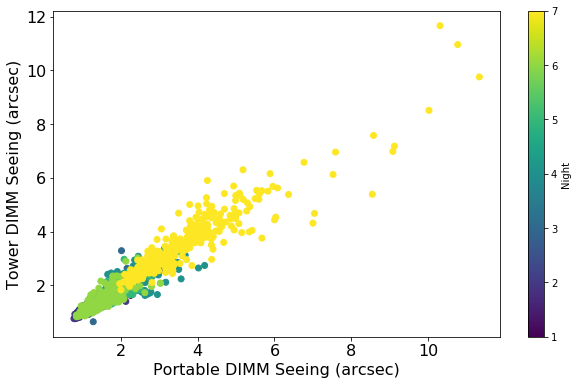

In [14]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(preat_df_port['full_seeing'].iloc[good_port_idx], 
            preat_df_tower['full_seeing'].iloc[near_tower_idx],
            c=preat_df_port['night'].iloc[good_port_idx])
plt.xlabel('Portable DIMM Seeing (arcsec)', size=16)
plt.ylabel('Tower DIMM Seeing (arcsec)', size=16)
plt.tick_params(axis='both', labelsize=16)
cbar = plt.colorbar(label='Night')

Finally, we plot the ratio between measurements from the two DIMMs

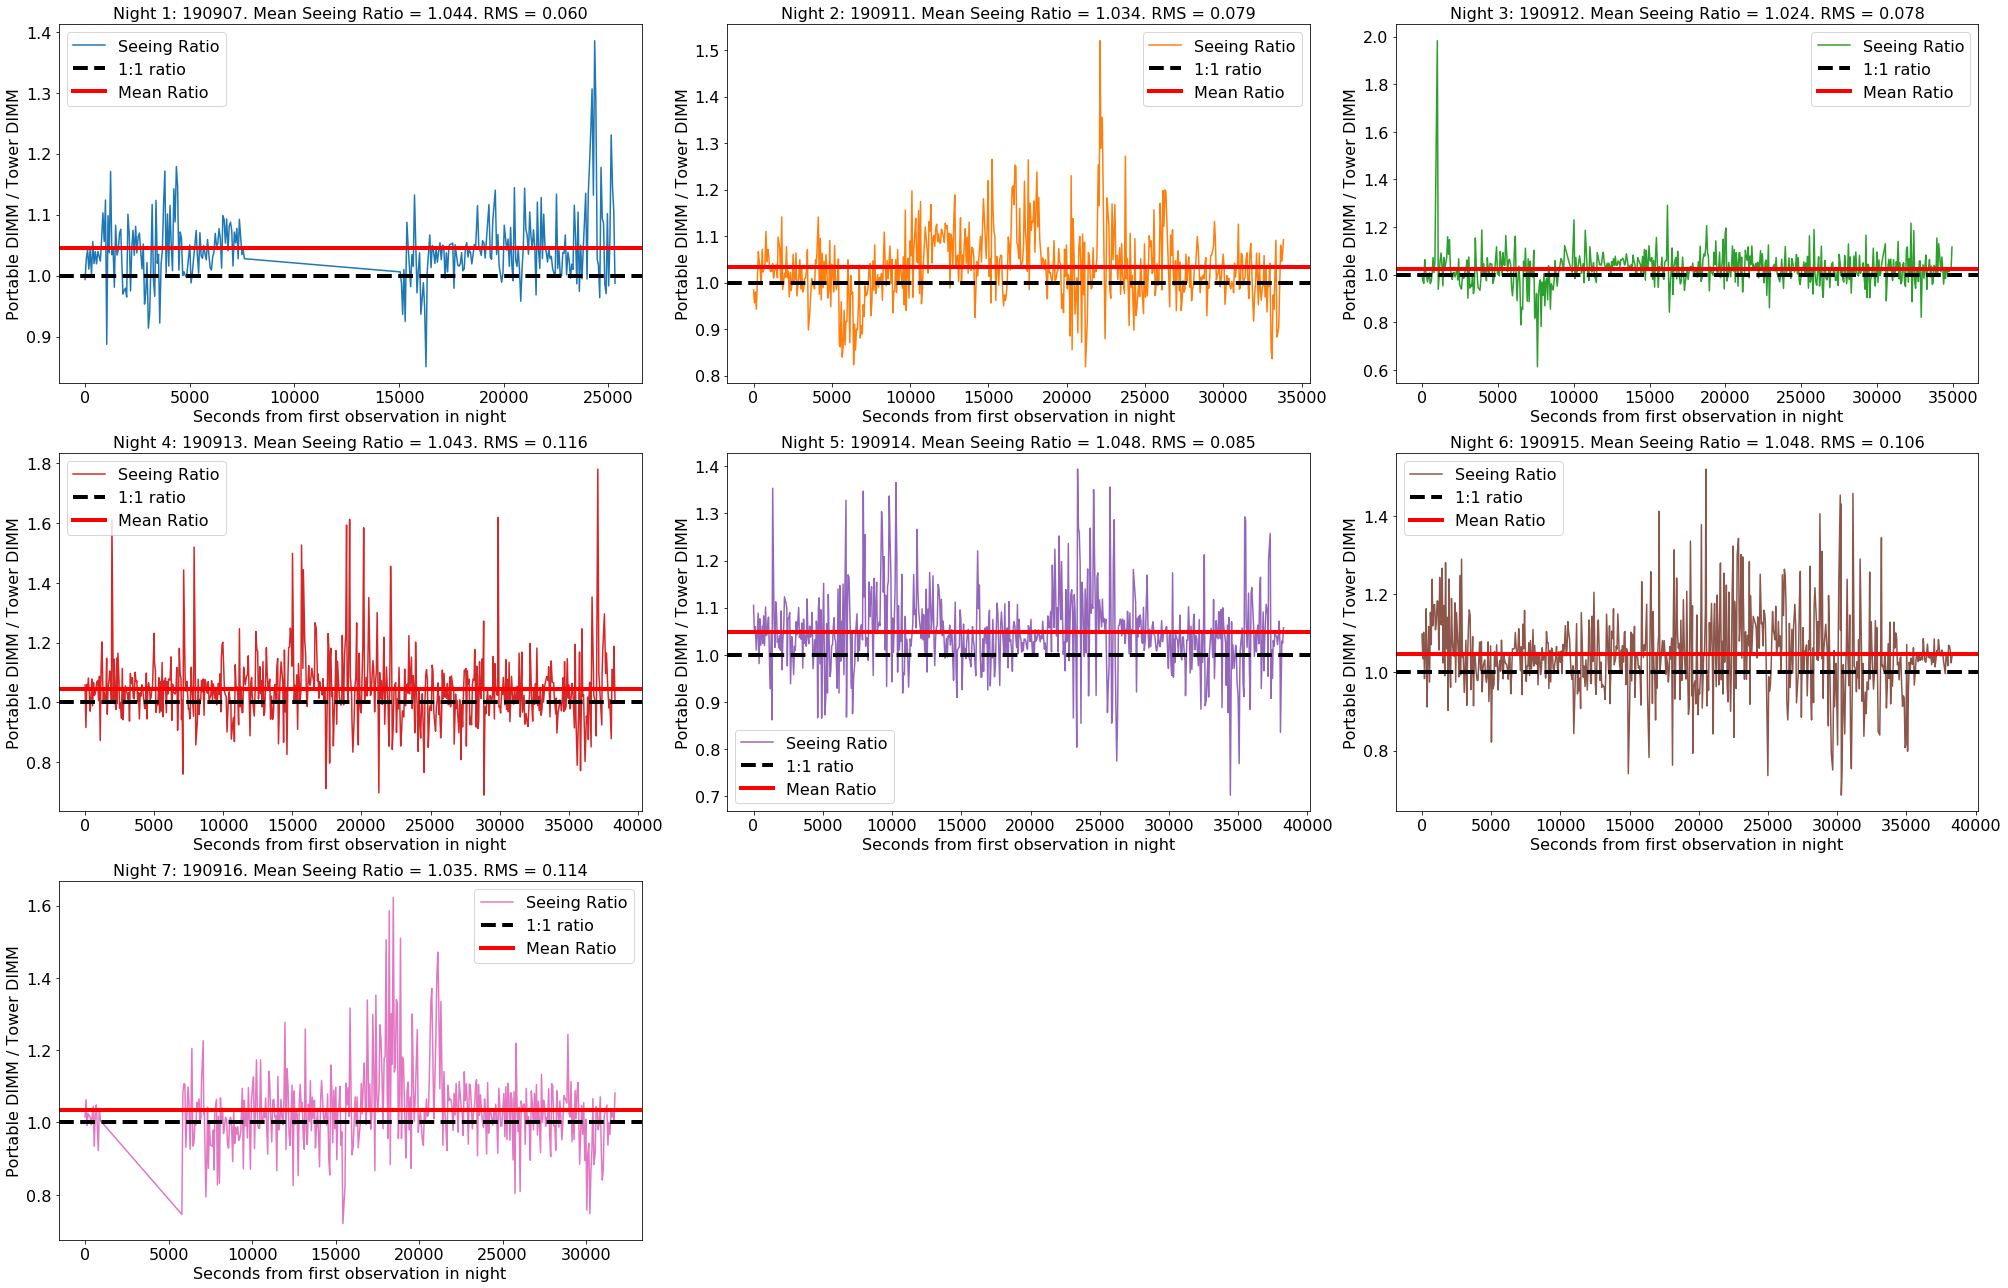

In [15]:
fig = plt.figure(figsize=(28, 18))
mean_ratios = []
for night in np.unique(preat_df_port['night']):
    fig.add_subplot(3, 3, night)
    night_port = preat_df_port.iloc[good_port_idx].query('night == %i' % night)
    night_tower = preat_df_tower.iloc[near_tower_idx].query('night == %i' % night)
    night_time = night_port['time_offset'].values - night_port['time_offset'].iloc[0]
    night_ratio = night_port['full_seeing'].values / night_tower['full_seeing'].values
    mean_ratio = np.mean(night_ratio)
    ratio_rms = np.sqrt(np.mean((night_ratio-mean_ratio)**2.))
    plt.plot(night_time,
             night_ratio, c='C%i' % (night-1), label='Seeing Ratio')
    plt.axhline(1., 0., 35000., c='k', lw=4, label='1:1 ratio', ls='--')
    plt.axhline(mean_ratio, 0., 35000., c='r', lw=4, label='Mean Ratio')
    plt.xlabel('Seconds from first observation in night', size=16)
    plt.ylabel('Portable DIMM / Tower DIMM', size=16)
    plt.tick_params(axis='both', labelsize=16)
    plt.title('Night %i: %s. Mean Seeing Ratio = %.3f. RMS = %.3f' % (night, obs_dates[night-1], mean_ratio, ratio_rms), size=16)
    plt.legend(fontsize=16)
    mean_ratios.append(mean_ratio)
plt.tight_layout()

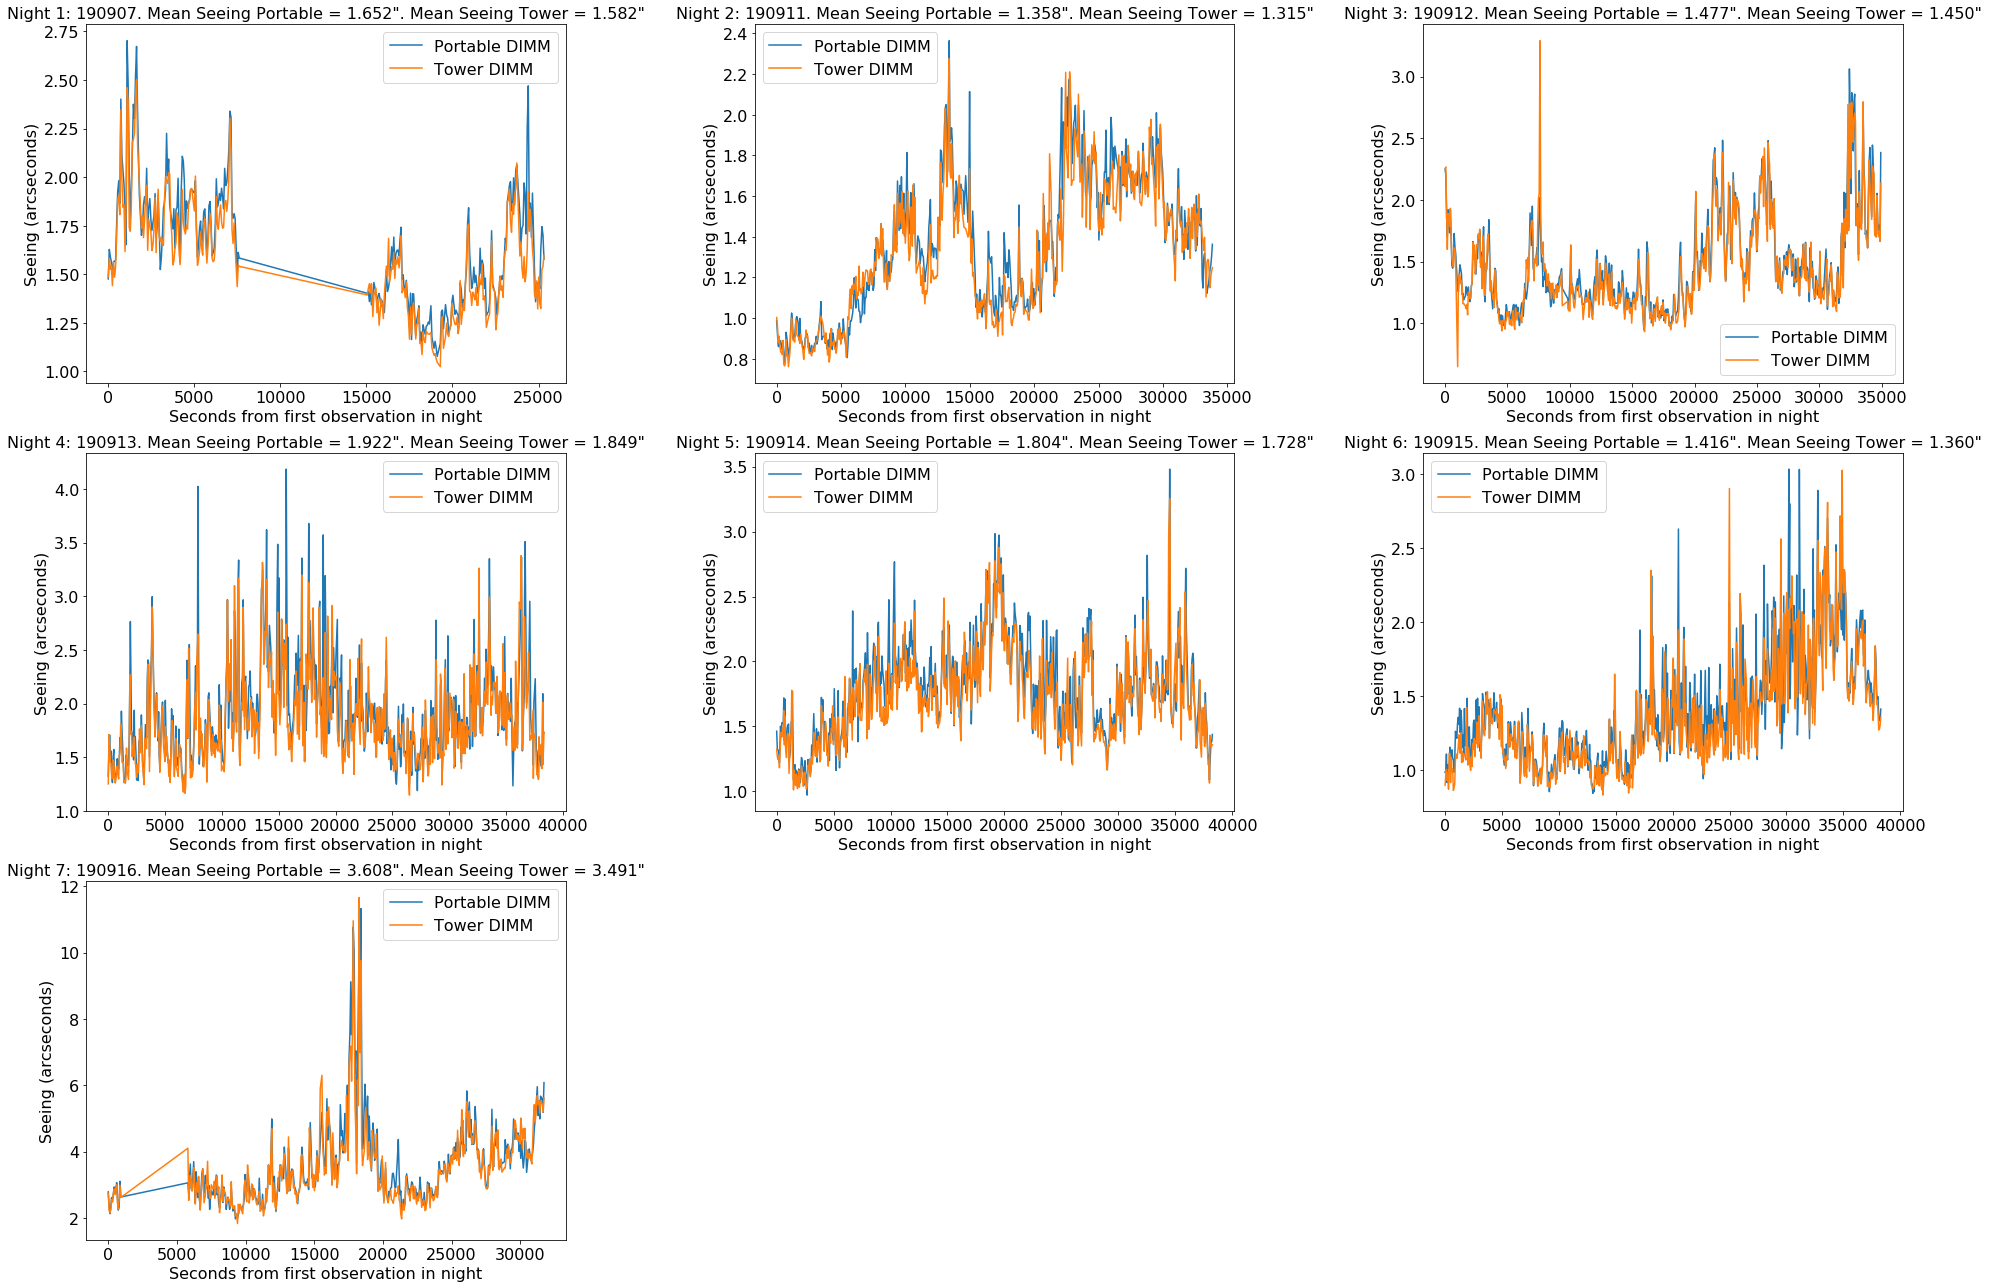

In [16]:
fig = plt.figure(figsize=(28, 18))
#mean_ratios = []
for night in np.unique(preat_df_port['night']):
    fig.add_subplot(3, 3, night)
    night_port = preat_df_port.iloc[good_port_idx].query('night == %i' % night)
    night_tower = preat_df_tower.iloc[near_tower_idx].query('night == %i' % night)
    night_time = night_port['time_offset'].values - night_port['time_offset'].iloc[0]
    plt.plot(night_time, night_port['full_seeing'].values, label='Portable DIMM')
    plt.plot(night_time, night_tower['full_seeing'].values, label='Tower DIMM')
    
    plt.xlabel('Seconds from first observation in night', size=16)
    plt.ylabel('Seeing (arcseconds)', size=16)
    plt.tick_params(axis='both', labelsize=16)
    plt.title('Night %i: %s. Mean Seeing Portable = %.3f". Mean Seeing Tower = %.3f"' % (night, obs_dates[night-1], 
                                                                                       np.mean(night_port['full_seeing'].values),
                                                                                       np.mean(night_tower['full_seeing'].values)), size=16)
    plt.legend(fontsize=16)
    mean_ratios.append(mean_ratio)
plt.tight_layout()

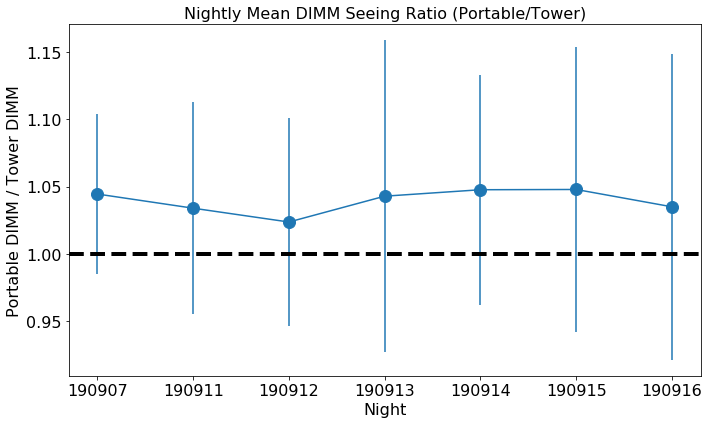

In [17]:
fig = plt.figure(figsize=(10, 6))
mean_ratios = []
rms_vals = []
nights = np.unique(preat_df_port['night'])
for night in nights:
    night_port = preat_df_port.iloc[good_port_idx].query('night == %i' % night)
    night_tower = preat_df_tower.iloc[near_tower_idx].query('night == %i' % night)
    night_time = night_port['time_offset'].values - night_port['time_offset'].iloc[0]
    night_ratio = night_port['full_seeing'].values / night_tower['full_seeing'].values
    mean_ratio = np.mean(night_ratio)
    mean_ratios.append(mean_ratio)
    ratio_rms = np.sqrt(np.mean((night_ratio-mean_ratio)**2.))
    rms_vals.append(ratio_rms)

plt.errorbar(nights, mean_ratios, yerr=rms_vals, marker='.', ms=24)
plt.axhline(1., 0., 7., c='k', lw=4, label='1:1 ratio', ls='--')
#plt.axhline(mean_ratio, 0., 35000., c='r', lw=4, label='Mean Ratio')
plt.xlabel('Night', size=16)
plt.ylabel('Portable DIMM / Tower DIMM', size=16)
plt.xticks(ticks=nights, labels=obs_dates)
plt.tick_params(axis='both', labelsize=16)
plt.title('Nightly Mean DIMM Seeing Ratio (Portable/Tower)', size=16)
#plt.legend(fontsize=16)

plt.tight_layout()

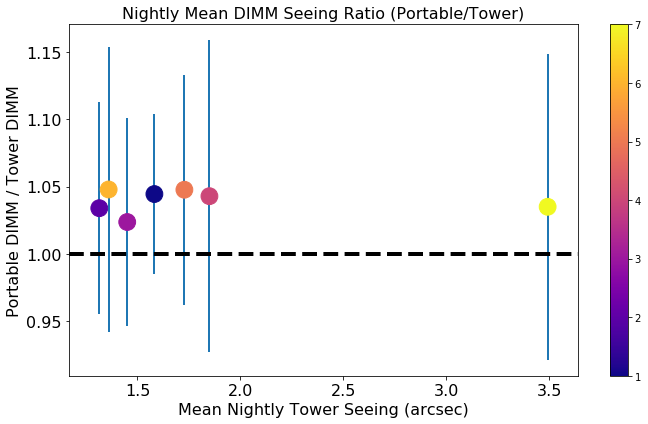

In [18]:
fig = plt.figure(figsize=(10, 6))
mean_ratios = []
mean_tower_seeing = []
rms_vals = []
nights = np.unique(preat_df_port['night'])
for night in nights:
    night_port = preat_df_port.iloc[good_port_idx].query('night == %i' % night)
    night_tower = preat_df_tower.iloc[near_tower_idx].query('night == %i' % night)
    night_time = night_port['time_offset'].values - night_port['time_offset'].iloc[0]
    night_ratio = night_port['full_seeing'].values / night_tower['full_seeing'].values
    mean_tower_seeing.append(np.mean(night_tower['full_seeing']))
    mean_ratio = np.mean(night_ratio)
    mean_ratios.append(mean_ratio)
    ratio_rms = np.sqrt(np.mean((night_ratio-mean_ratio)**2.))
    rms_vals.append(ratio_rms)

plt.errorbar(mean_tower_seeing, mean_ratios, yerr=rms_vals, marker='.', 
             ms=24, elinewidth=2, lw=0)
plt.scatter(mean_tower_seeing, mean_ratios, c=nights, zorder=100, s=282, cmap=plt.get_cmap('plasma'))
plt.colorbar()
plt.axhline(1., 0., 7., c='k', lw=4, label='1:1 ratio', ls='--')
#plt.axhline(mean_ratio, 0., 35000., c='r', lw=4, label='Mean Ratio')
plt.xlabel('Mean Nightly Tower Seeing (arcsec)', size=16)
plt.ylabel('Portable DIMM / Tower DIMM', size=16)
#plt.xticks(ticks=nights, labels=obs_dates)
plt.tick_params(axis='both', labelsize=16)
plt.title('Nightly Mean DIMM Seeing Ratio (Portable/Tower)', size=16)
#plt.legend(fontsize=16)

plt.tight_layout()

## Additional potentially useful plots

In [19]:
preat_df_port['matched_id'] = -99
preat_df_port.loc[good_port_idx, 'matched_id'] = good_port_idx

In [20]:
preat_df_tower['matched_id'] = -99
preat_df_tower.loc[near_tower_idx, 'matched_id'] = good_port_idx

In [21]:
# Perform linear fit for portable vs tower DIMM seeing
slopes = []
intercepts = []
for night in np.unique(preat_df_port['night']):
    print(night)
    r = stats.linregress(preat_df_port.iloc[good_port_idx].query('night == %i' % night)['full_seeing'],
                         preat_df_tower.iloc[near_tower_idx].query('night == %i' % night)['full_seeing'])
    slopes.append(r.slope)
    intercepts.append(r.intercept)

1
2
3
4
5
6
7


In [22]:
slopes, intercepts, 1/np.array(slopes)

([0.8755297048456164,
  0.8928479026462345,
  0.9713703174978007,
  0.7823250284302682,
  0.8830023013414844,
  0.8950349963470691,
  0.8457097570947844],
 [0.13616153853418966,
  0.1022478730092593,
  0.015169102164159565,
  0.34580403256165715,
  0.1348597691680673,
  0.09269748868393446,
  0.44032062373017],
 array([1.1421657 , 1.12001159, 1.0294735 , 1.27824109, 1.13249988,
        1.11727475, 1.18243876]))

Text(0.5, 1.0, 'Linear Fits to DIMM 1 vs DIMM 2 per night')

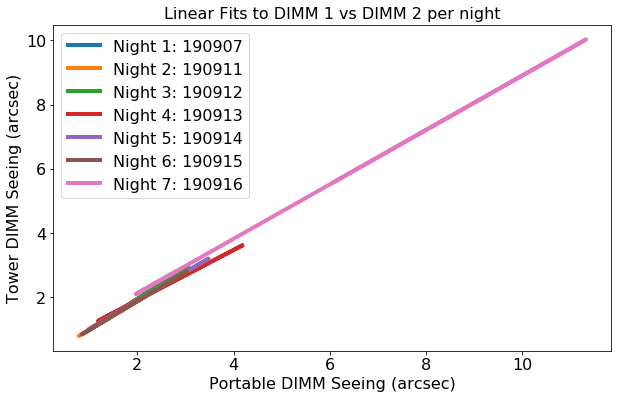

In [23]:
fig = plt.figure(figsize=(10, 6))
for night in np.unique(preat_df_port['night']):
    port_seeing = preat_df_port.iloc[good_port_idx].query('night == %i' % night)['full_seeing']
    tower_seeing = preat_df_tower.iloc[near_tower_idx].query('night == %i' % night)['full_seeing']
    plt.plot(port_seeing,
             port_seeing*slopes[night-1] + intercepts[night-1], c='C%i' % (night-1), 
             label='Night %i: %s' % (night, obs_dates[night-1]), lw=4)
    #plt.scatter(port_seeing, tower_seeing, c='C%i' % (night-1), alpha=0.25, s=120, marker='+')
plt.xlabel('Portable DIMM Seeing (arcsec)', size=16)
plt.ylabel('Tower DIMM Seeing (arcsec)', size=16)
plt.tick_params(axis='both', labelsize=16)
plt.legend(fontsize=16)
plt.title('Linear Fits to DIMM 1 vs DIMM 2 per night', size=16)

Text(0.5, 1.0, 'Linear Fits to DIMM 1 vs DIMM 2 per night')

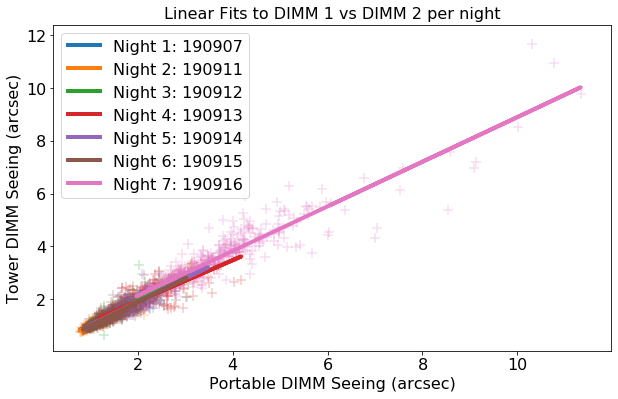

In [24]:
fig = plt.figure(figsize=(10, 6))
for night in np.unique(preat_df_port['night']):
    port_seeing = preat_df_port.iloc[good_port_idx].query('night == %i' % night)['full_seeing']
    tower_seeing = preat_df_tower.iloc[near_tower_idx].query('night == %i' % night)['full_seeing']
    plt.plot(port_seeing,
             port_seeing*slopes[night-1] + intercepts[night-1], c='C%i' % (night-1), 
             label='Night %i: %s' % (night, obs_dates[night-1]), lw=4)
    plt.scatter(port_seeing, tower_seeing, c='C%i' % (night-1), alpha=0.25, s=120, marker='+')
plt.xlabel('Portable DIMM Seeing (arcsec)', size=16)
plt.ylabel('Tower DIMM Seeing (arcsec)', size=16)
plt.tick_params(axis='both', labelsize=16)
plt.legend(fontsize=16)
plt.title('Linear Fits to DIMM 1 vs DIMM 2 per night', size=16)

Text(0.5, 1.0, 'Normalized histogram of Portable DIMM seeing values')

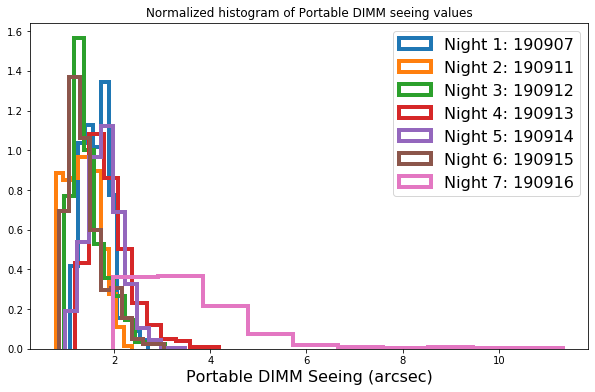

In [25]:
fig = plt.figure(figsize=(10, 6))
for night in np.unique(preat_df_port['night']):
    port_seeing = preat_df_port.iloc[good_port_idx].query('night == %i' % night)['full_seeing']
    tower_seeing = preat_df_tower.iloc[near_tower_idx].query('night == %i' % night)['full_seeing']
    plt.hist(port_seeing, color='C%i' % (night-1), histtype='step',
             label='Night %i: %s' % (night, obs_dates[night-1]), lw=4, density=True)
    #plt.scatter(port_seeing, tower_seeing, c='C%i' % (night-1), alpha=0.25, s=120, marker='+')
plt.xlabel('Portable DIMM Seeing (arcsec)', size=16)
#plt.ylabel('Tower DIMM Seeing (arcsec)', size=16)
#plt.tick_params(axis='both', labelsize=16)
plt.legend(fontsize=16)
#plt.title('Linear Fits to DIMM 1 vs DIMM 2 per night', size=16)
plt.title('Normalized histogram of Portable DIMM seeing values')

Text(0.5, 1.0, 'Normalized histogram of Tower DIMM seeing values')

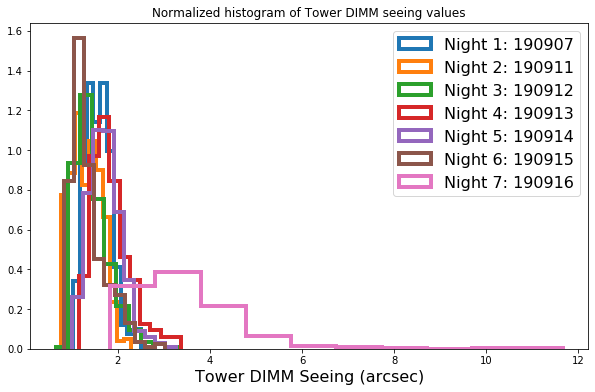

In [26]:
fig = plt.figure(figsize=(10, 6))
for night in np.unique(preat_df_port['night']):
    port_seeing = preat_df_port.iloc[good_port_idx].query('night == %i' % night)['full_seeing']
    tower_seeing = preat_df_tower.iloc[near_tower_idx].query('night == %i' % night)['full_seeing']
    plt.hist(tower_seeing, color='C%i' % (night-1), histtype='step',
             label='Night %i: %s' % (night, obs_dates[night-1]), lw=4, density=True)
    #plt.scatter(port_seeing, tower_seeing, c='C%i' % (night-1), alpha=0.25, s=120, marker='+')
#plt.xlabel('Portable DIMM Seeing (arcsec)', size=16)
plt.xlabel('Tower DIMM Seeing (arcsec)', size=16)
#plt.tick_params(axis='both', labelsize=16)
plt.legend(fontsize=16)
#plt.title('Linear Fits to DIMM 1 vs DIMM 2 per night', size=16)
plt.title('Normalized histogram of Tower DIMM seeing values')

In [27]:
# Add column identifying matched rows
preat_df_port['matched'] = 0
preat_df_port['matched'].iloc[good_port_idx] = 1
preat_df_tower['matched'] = 0
preat_df_tower['matched'].iloc[near_tower_idx] = 1

/phys/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


## Future Work

In the future we would like to incorporate weather data to look for correlations with our DIMM data. Corner plots could be useful so just some playing around with `corner.py` is below.

In [28]:
good_tower = preat_df_tower.query('matched_id != -99')
good_port = preat_df_port.query('matched_id != -99')

In [29]:
matched_df = good_port.merge(good_tower, on='matched_id', suffixes=['_portable', '_tower'])

In [30]:
matched_df['dimm_ratio'] = matched_df['full_seeing_portable'] / matched_df['full_seeing_tower']

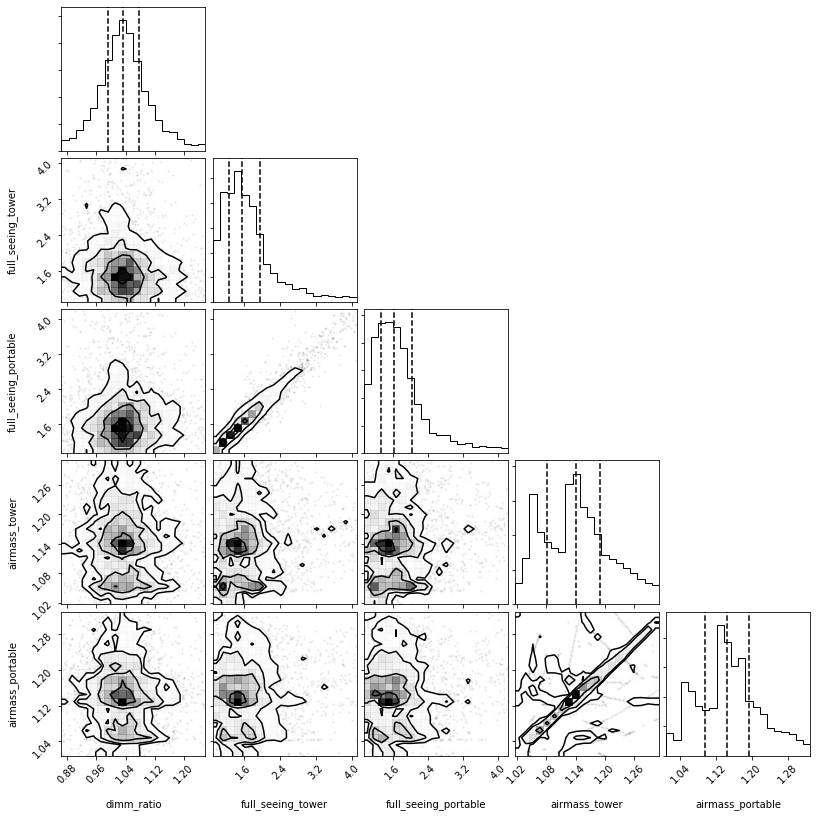

In [31]:
cplot = corner.corner(matched_df[['dimm_ratio', 'full_seeing_tower', 'full_seeing_portable', 'airmass_tower', 'airmass_portable', ]],
                      range=[.95]*5, quantiles=[.25, .5, .75])